# Atividade 03: *Dropout*

*Complete e entregue toda essa atividade (incluindo suas saídas e qualquer código adicional que você desenvolva) juntamente com a submissão de seu trabalho prático. Maiores detalhes podem ser vistos na página da disciplina.*

*Dropout* [1] é uma técnica para regularização de redes neurais por meio da atribuição de zero para algumas características (*features*) de forma aleatória durante o *forward pass*. 

Nesta atividadem, você irá imeplementar uma camada de *dropout* e modificar sua implementação de rede completamente conectada para opcionalmente utilizar essa técnica.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [2]:
# Executa algum código de inicialização desse notebook.
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from dl.classifiers.fc_net import *
from dl.data_utils import get_CIFAR10_data
from dl.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from dl.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # fixa tamanho default para as plotagens
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Um pouco mais de 'mágica', assim o notebook irá recarregar módulos python externos;
# veja mais em http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Carrega os dados brutos da base CIFAR-10.
# Para tanto, você deve ter feito o download de http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# e descompactado no diretório 'dl/datasets/cifar-10-batches-py'

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Camada de *Dropout*: *forward pass*

No arquivo `dl/layers.py`, você deverá implementar o *forward pass* da camada de *dropout* na função `dropout_forward`. Uma vez que a técnica de *dropout* funciona completamente diferente durante os modos de treino e teste, você deve se assegurar de implementar a operação para ambos os modos.

Uma vez que você tenha terminado, execute o seguinte código para testar sua implementação:

In [9]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.3
Mean of input:  10.000207878477502
Mean of train-time output:  9.98526577051765
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.300876
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.000207878477502
Mean of train-time output:  10.035153558044966
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.598632
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.000207878477502
Mean of train-time output:  10.021625749126565
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749504
Fraction of test-time output set to zero:  0.0



# Camada de *Dropout*: *backward pass*

No arquivo `dl/layers.py`, você deverá implementar o *backward pass* da camada de *dropout* na função `dropout_backward`. 
Depois disso, execute o seguinte código para verificar numericamente sua implementação:

In [10]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.8929048652720146e-11


# Redes Completamente Conectadas com *Dropout*

No arquivo `dl/classifiers/fc_net.py`, você deverá estudar a parte da implementação de rede completamente conectada que utiliza *dropout*.

Mais especificamente, se o construtor da rede receber um valor não-nulo para o parâmetro `dropout`, então será adicionada uma camada de *dropout* imediatamente depois de cada camada não-linear ReLU.

Depois de seu estudo, execute o seguinte código para verificar numericamente a implementação:

In [11]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

Running check with dropout =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.25
Initial loss:  2.3076744135822236
W1 relative error: 4.05e-08
W2 relative error: 1.38e-06
W3 relative error: 8.67e-08
b1 relative error: 3.56e-09
b2 relative error: 6.90e-09
b3 relative error: 1.31e-10

Running check with dropout =  0.5
Initial loss:  2.3181949171427405
W1 relative error: 9.88e-09
W2 relative error: 2.85e-08
W3 relative error: 1.11e-08
b1 relative error: 2.58e-09
b2 relative error: 8.45e-10
b3 relative error: 1.66e-10



# Experimento de Regularização

De forma a realizar experimentos com a camada de *dropout* implementada, você irá usar o código na próxima célula para treinar um par de redes de duas camadas sobre 500 amostras de treino: uma não irá usar *dropout*, enquanto a outra irá utilizar *dropout* com uma probabilidade de 0,75. 

Na célula seguinte, você irá encontrar código para produzir visualizações das acurácias de treinamento e validação das duas redes ao longo do tempo.

In [12]:
# Treinar duas redes idênticas, uma com 'dropout e outra sem
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout=dropout)
    print(dropout)

    solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver

0
(Iteration 1 / 125) loss: 7.856644
(Epoch 0 / 25) train acc: 0.274000; val_acc: 0.192000
(Epoch 1 / 25) train acc: 0.408000; val_acc: 0.265000
(Epoch 2 / 25) train acc: 0.516000; val_acc: 0.269000
(Epoch 3 / 25) train acc: 0.566000; val_acc: 0.247000
(Epoch 4 / 25) train acc: 0.676000; val_acc: 0.292000
(Epoch 5 / 25) train acc: 0.770000; val_acc: 0.286000
(Epoch 6 / 25) train acc: 0.790000; val_acc: 0.281000
(Epoch 7 / 25) train acc: 0.822000; val_acc: 0.258000
(Epoch 8 / 25) train acc: 0.886000; val_acc: 0.300000
(Epoch 9 / 25) train acc: 0.906000; val_acc: 0.300000
(Epoch 10 / 25) train acc: 0.910000; val_acc: 0.279000
(Epoch 11 / 25) train acc: 0.938000; val_acc: 0.296000
(Epoch 12 / 25) train acc: 0.944000; val_acc: 0.318000
(Epoch 13 / 25) train acc: 0.962000; val_acc: 0.288000
(Epoch 14 / 25) train acc: 0.974000; val_acc: 0.293000
(Epoch 15 / 25) train acc: 0.954000; val_acc: 0.302000
(Epoch 16 / 25) train acc: 0.972000; val_acc: 0.301000
(Epoch 17 / 25) train acc: 0.972000; v

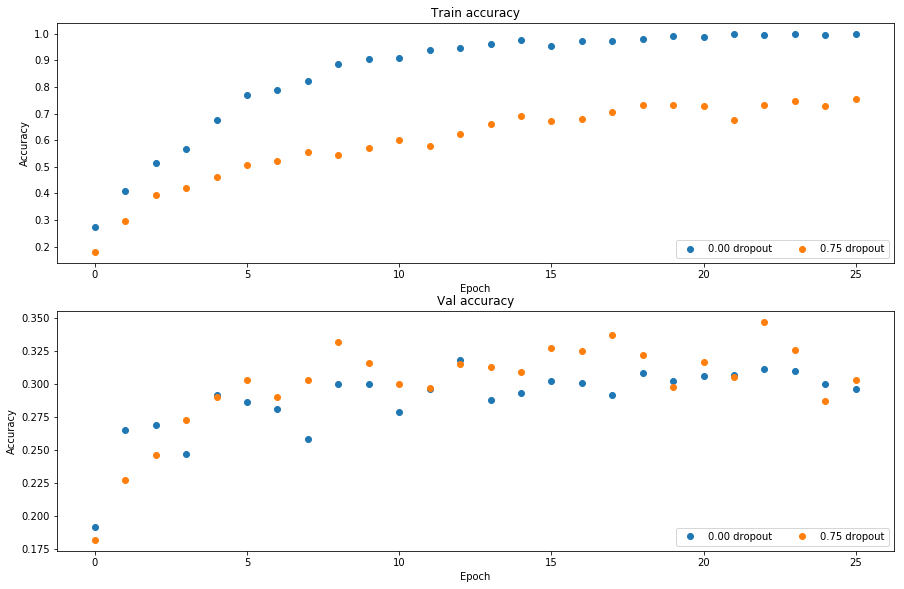

In [13]:
# 'Plota' acurácias de treinamento e validação para as duas redes

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
    
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
    
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Pergunta #01:

Explique o que você observou neste último experimento. O que ele sugere sobre a técnica de *dropout*?

# Resposta:
Apesar da rede sem Dropout ter valores de treinamento superiores aos obtidos na rede com Dropout, o resultado d validação é melhor para rede com Dropout. Isso indica caracterísitcas de overfitting, onde a rede aprendeu os dados mas não foi capaz de generalizar a informação.